In [1]:
import sys
sys.path.insert(0, './src/')

from table_extractor import TableExtractor
from card_extractor import CardExtractor
from card_classifier import CardClassifier
from chip_counter import ChipCounter

import os
import PIL.Image
import time

from evaluation_utils import eval_listof_games, eval_listof_games_per_category , debug_listof_games, save_results , load_results
import pandas as pd

import numpy as np
from collections import defaultdict


%load_ext autoreload
%autoreload 2

In [2]:
def process_image(image, plot=False) -> dict:
    """
    Process image and return information. To return the value of the cards we use 
    the following format: {number}{color}. Where 
        - color is either (D)imanond, (H)eart, (S)pade, (C)lub
        - number is either 2-10, (J)ack, (Q)ueen, (K)ing. A(s).
            
    Parameters
    ----------
    image:
        Input image to process

    Returns
    -------
    results:
        - T1 (str): String code of the first card of the flop (far left) 
        - T2 (str): String code of the second card of the flop
        - T3 (str): String code of the third card of the flop
        - T4 (str): String code of the turn
        - T5 (str): String code of the river
        - P11 (str or int): String code of player 1 card 1. Should be 0 if player 1 is not Playing.
        - P12 (str or int): String code of player 1 card 2. Should be 0 if player 1 is not Playing.
        - P21 (str or int): String code of player 2 card 1. Should be 0 if player 2 is not Playing.
        - P22 (str or int): String code of player 2 card 2. Should be 0 if player 2 is not Playing.
        - P31 (str or int): String code of player 3 card 1. Should be 0 if player 3 is not Playing.
        - P32 (str or int): String code of player 3 card 2. Should be 0 if player 3 is not Playing.
        - P41 (str or int): String code of player 4 card 1. Should be 0 if player 4 is not Playing.
        - P42 (str or int): String code of player 4 card 2. Should be 0 if player 4 is not Playing.
        - CR (int): Number of (r)ed chips in the pot
        - CG (int): Number of (g)reen chips in the pot
        - CB (int): Number of (b)lue chips in the pot
        - CK (int): Number of blac(k) chips in the pot
        - CW (int): Number of (w)hite chips in the pot
        
    Examples
    --------
    - QH: Queen of hearths
    - 10S: 10 of spades
    - AC: Ace f clubs

    """
    def def_value():
        return "0"
      
    results = defaultdict(def_value)
    
    image = np.array(image)
    
    # Extract table
    table_img = TableExtractor.extract_table(image, plot=plot)
    
    # Extract cards
    card_extractor = CardExtractor(table_img)
    
    
    # Classify bottom cards
    table_card_keys = ["T1", "T2", "T3", "T4", "T5"]
    table_cards = card_extractor.extract_table_cards(plot=plot)
    CardClassifier.classify_cards(table_cards, table_card_keys, results, can_use_both_corners=True, plot=plot)
    
    players = ["P1", "P2", "P3", "P4"]
    for player in players:
        if (plot):
            print(player)
        c1, c2 = card_extractor.extract_player_cards(player, plot=plot)
        
        first_card_name = player + "1"
        second_card_name = player + "2"

        is_face_down = False
        if (type(c1) != type(None)):
            is_face_down |= CardClassifier.is_card_face_down(c1, plot=plot)
            if(not is_face_down):
                results[first_card_name], _ = CardClassifier.classify_card(c1, can_use_both_corners=False, plot =plot)
                
        if (type(c2) != type(None)):
            is_face_down |= CardClassifier.is_card_face_down(c2, plot=plot)
            if(not is_face_down):
                results[second_card_name], _ = CardClassifier.classify_card(c2, can_use_both_corners=False, plot=plot)
        if(is_face_down):
            results[first_card_name] = "0"
            results[second_card_name] = "0"
            
    # Chips
    ChipCounter.count_chips(table_img, results, plot=plot)
    
    return results

# Evaluation

In [3]:
path_data = "data/train"
group_id = 0

In [4]:
# load train size dataset
train_size = np.loadtxt(os.path.join(path_data, "train_size.txt")).astype(int)
print("Size of trainset:\n\t{}".format(train_size))

# Load images from folder
game_results = {}

# Evaluate training images
games_id = range(28)


for i in games_id :
    print(f"Game {i}")

    start_time = time.time()
    file = os.path.join(path_data, f"train_{str(i).zfill(2)}.jpg")
    # open the image
    im = PIL.Image.open(file)
    # Process the image
    results = process_image(image=im, plot= False)
    # Append result to array
    game_results[i] = results
    
    print(f"Predicted game {i} in {time.time() - start_time}s")
    #print("Prediciton game:\n\t{}: {}".format(0, game_results[i])) #overlay

# Saving results
file_results = save_results(results=game_results, groupid=group_id)

Size of trainset:
	28
Game 0
Predicted game 0 in 4.45878791809082s
Game 1
Predicted game 1 in 3.9034409523010254s
Game 2
Predicted game 2 in 4.470877170562744s
Game 3
Predicted game 3 in 3.471303939819336s
Game 4
Predicted game 4 in 4.54096794128418s
Game 5
Predicted game 5 in 5.283191919326782s
Game 6
Predicted game 6 in 3.648167848587036s
Game 7
Predicted game 7 in 4.732647895812988s
Game 8
Predicted game 8 in 3.8000969886779785s
Game 9
Predicted game 9 in 3.9005448818206787s
Game 10
Predicted game 10 in 4.212562322616577s
Game 11
Predicted game 11 in 6.1962480545043945s
Game 12
Warning circle with no thresholded color: set to label of closest color mean
Warning circle with no thresholded color: set to label of closest color mean
Predicted game 12 in 4.050580978393555s
Game 13
Predicted game 13 in 5.7721710205078125s
Game 14
Predicted game 14 in 3.7965848445892334s
Game 15
Predicted game 15 in 5.102826833724976s
Game 16
Predicted game 16 in 4.443939924240112s
Game 17
Predicted game 1

In [5]:
# Checking the results were loaded correctly
loaded_results = load_results(file_results)
print(loaded_results.keys())

game_labels = pd.read_csv('data/train/train_labels.csv')
game_labels = game_labels.fillna('0')

dict_keys(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27'])


In [6]:
eval_listof_games_per_category(game_results , game_labels , game_id = games_id)

Game 0 results
Num: 1.0
Suits: 1.0
Chips:1.0
________________________________________
Game 1 results
Num: 1.0
Suits: 1.0
Chips:1.0
________________________________________
Game 2 results
Num: 1.0
Suits: 0.9230769230769231
Chips:1.0
________________________________________
Game 3 results
Num: 0.9230769230769231
Suits: 1.0
Chips:1.0
________________________________________
Game 4 results
Num: 0.6923076923076923
Suits: 0.46153846153846156
Chips:0.875
________________________________________
Game 5 results
Num: 0.9230769230769231
Suits: 0.8461538461538461
Chips:1.0
________________________________________
Game 6 results
Num: 0.9230769230769231
Suits: 0.6153846153846154
Chips:1.0
________________________________________
Game 7 results
Num: 1.0
Suits: 1.0
Chips:1.0
________________________________________
Game 8 results
Num: 1.0
Suits: 0.9230769230769231
Chips:1.0
________________________________________
Game 9 results
Num: 0.8461538461538461
Suits: 0.8461538461538461
Chips:1.0
_____________

Current best on training set
- Average SCORE num =  0.9478021978021979
- Average SCORE suits =  0.925824175824176
- Average SCORE chips =  0.9900412087912088

In [8]:
eval_listof_games( game_results , game_labels , game_id = games_id)

Game 0 results
Estimated game
['2C', '6H', '8D', 'JC', 'JS', '2H', '4S', 'KS', 'QS', 'KD', '5S', '7H', '8C', 1, 1, 1, 1, 1]
True game
['2C' '6H' '8D' 'JC' 'JS' '2H' '4S' 'KS' 'QS' 'KD' '5S' '7H' '8C' 1 1 1 1
 1]


             	scores
Card number 	1.0 %
Card suit   	1.0 %
Chips       	1.0 %


FINAL score 	1.0 %
________________________________________
Game 1 results
Estimated game
['9H', '8C', '2H', '4C', 'JS', '0', '0', '3C', 'KH', 'KD', '2D', 'QS', '3S', 2, 0, 1, 0, 1]
True game
['9H' '8C' '2H' '4C' 'JS' '0' '0' '3C' 'KH' 'KD' '2D' 'QS' '3S' 2 0 1 0 1]


             	scores
Card number 	1.0 %
Card suit   	1.0 %
Chips       	1.0 %


FINAL score 	1.0 %
________________________________________
Game 2 results
Estimated game
['9D', '3D', '4C', '6D', '2H', '7H', 'QD', '10S', '10S', '5C', '4S', '2S', '4H', 0, 0, 8, 1, 0]
True game
['9D' '3D' '4C' '6D' '2H' '7H' 'QD' '10S' '10C' '5C' '4S' '2S' '4H' 0 0 8
 1 0]


             	scores
Card number 	1.0 %
Card suit   	0.92 %
Chips       	1.0 %


0.9545558608058607

Best training set score: 0.9545558608058607  
- Solved: 0, 1, 7, 10, 15, 17, 20, 21, 24, 25, 26, 27
- Difficult: 4, 6, 12, 23

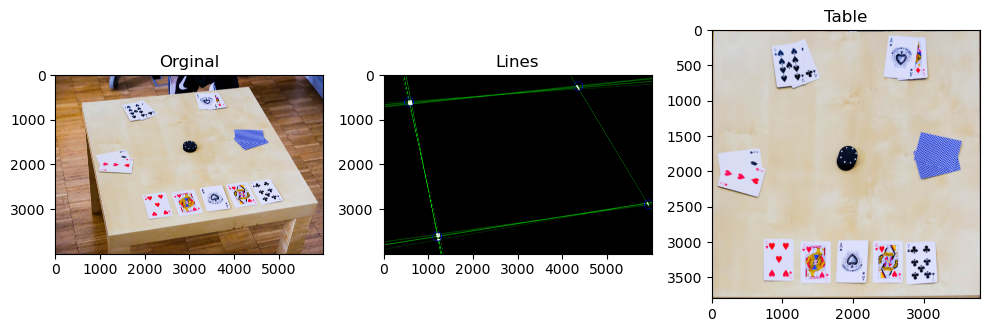

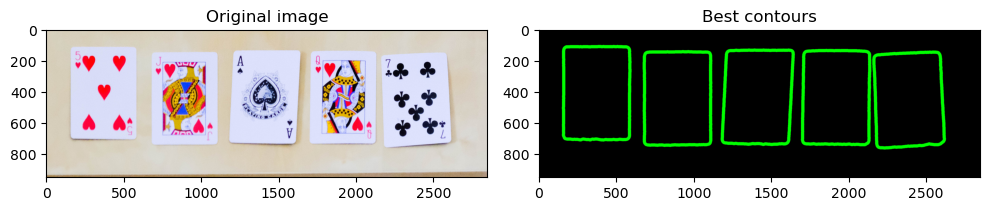

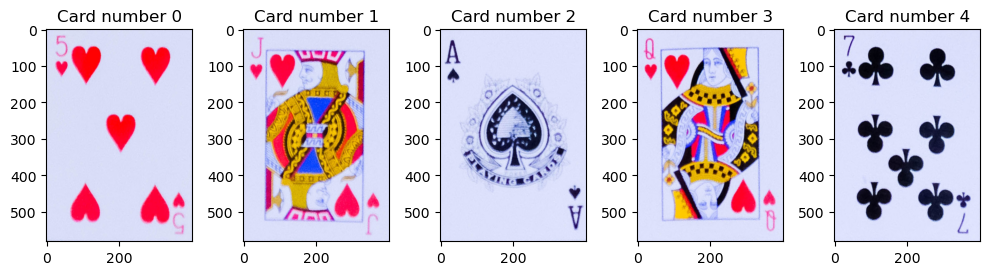

Predicted: 5H with score char:0.6763888888888889, symbol:0.8216106014271152
Predicted: JH with score char:0.8046875, symbol:0.8267074413863404
Predicted: AS with score char:0.7555350553505535, symbol:0.659016393442623
Predicted: QH with score char:0.8297619047619048, symbol:0.8757637474541752
Predicted: 7C with score char:0.7633928571428571, symbol:0.8646616541353384
P1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Extracted player card with height pipeline: is top card:True
Extracted player card with height pipeline: is top card:False


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


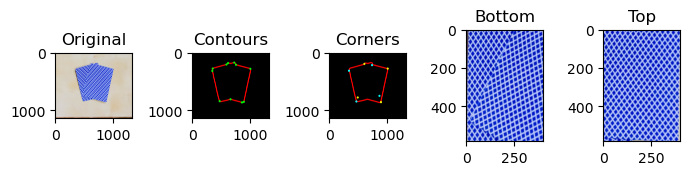

FACE DOWN
FACE DOWN
P2
Extracted player card with width pipeline: is top card:False


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Extracted player card with height pipeline: is top card:True


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


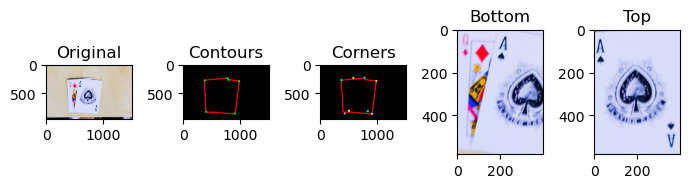

Predicted: QD with score char:0.5543933054393305, symbol:0.62248322147651
Predicted: AS with score char:0.6535008976660682, symbol:0.4988962472406181
P3


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Extracted player card with height pipeline: is top card:False
Extracted player card with height pipeline: is top card:True


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


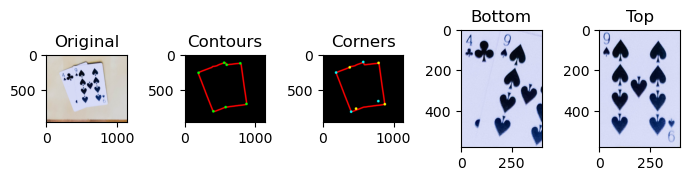

Predicted: 4S with score char:0.5555555555555556, symbol:0.7247899159663865
Predicted: 9S with score char:0.32774869109947646, symbol:0.7752442996742671
P4
Extracted player card with height pipeline: is top card:True
Extracted player card with height pipeline: is top card:False


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


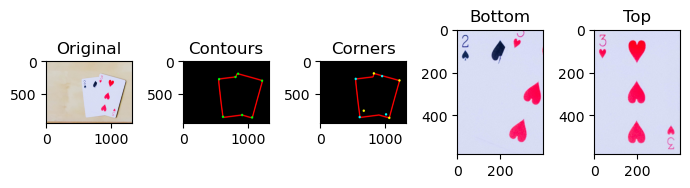

Predicted: 2S with score char:0.7720125786163522, symbol:0.8170865279299014
Predicted: 3H with score char:0.7293447293447294, symbol:0.883130081300813


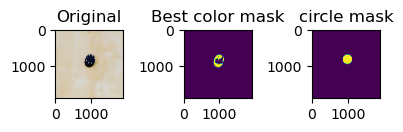

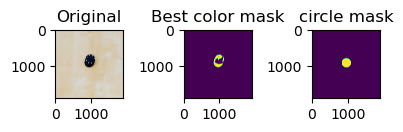

In [10]:
# open the image
im = PIL.Image.open("./data/image_setup/ultimate_test.jpg")
# Process the image
results = process_image(image=im, plot= True)